In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from umap import UMAP
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [17]:
df = pd.read_excel('marketing_campaign.xlsx')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [18]:
df.dropna(subset=['Income'], inplace=True)
df.drop_duplicates(inplace=True)

In [19]:
df = df.drop(['Z_CostContact', 'Z_Revenue', 'ID'], axis=1)

In [20]:
df['Age'] = 2025 - df['Year_Birth']
df['CustomerForYears'] = 2025 - df['Dt_Customer'].dt.year
df['TotalSpent'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts',
                       'MntSweetProducts','MntGoldProds']].sum(axis=1)
df['FamilySize'] = df['Kidhome'] + df['Teenhome'] + 1
df['Kids_Teens'] = df['Kidhome'] + df['Teenhome']
df['TotalAcceptedCmp'] = df[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3',
                             'AcceptedCmp4','AcceptedCmp5']].sum(axis=1)

# Ratios and new insights
df['SpendingEfficiency'] = df['TotalSpent'] / df['Income']
df['CampaignSuccessRate'] = df['TotalAcceptedCmp'] / 5

In [21]:
features = ['Income','Age','TotalSpent','Kids_Teens','FamilySize',
            'TotalAcceptedCmp','CustomerForYears','SpendingEfficiency','CampaignSuccessRate']

X = df[features]

In [22]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

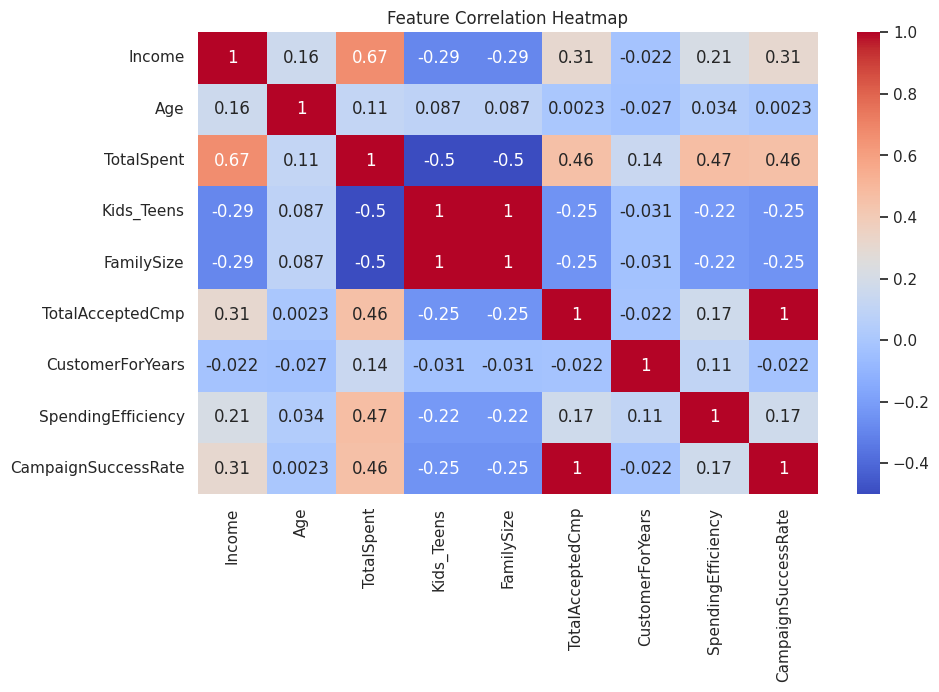

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(X, columns=features).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

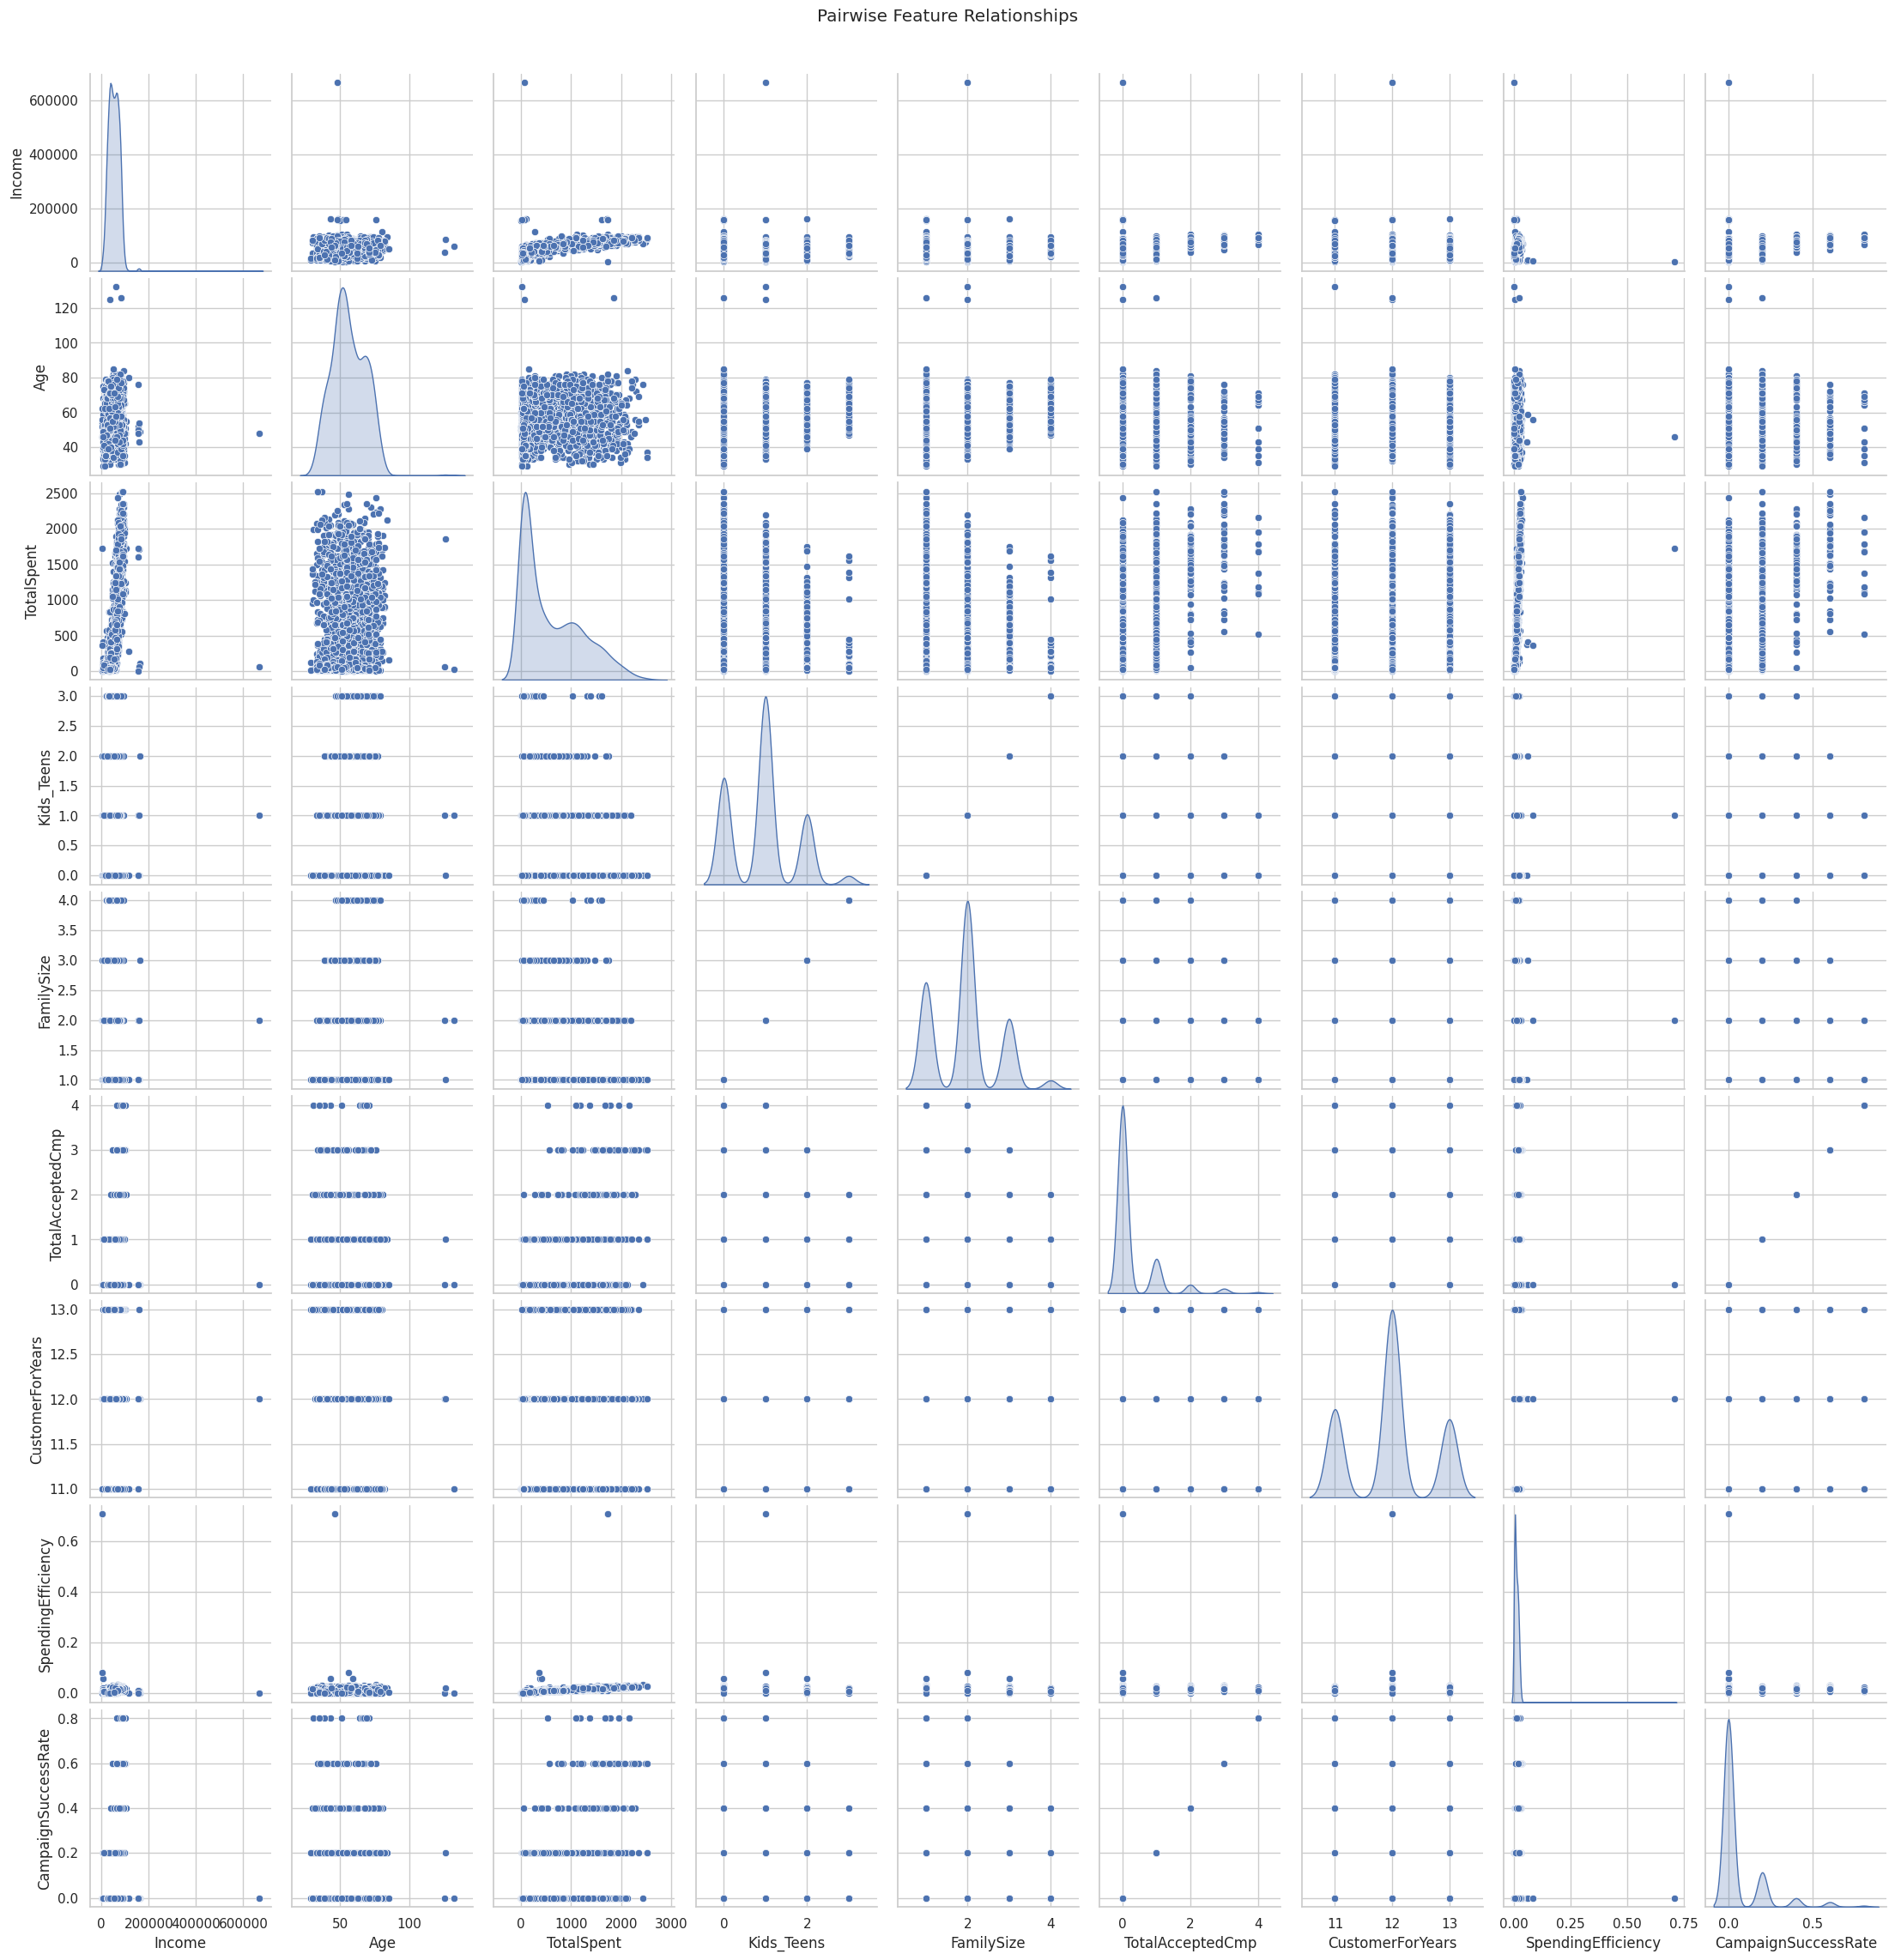

In [24]:
sns.pairplot(df[features], diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

Model Building

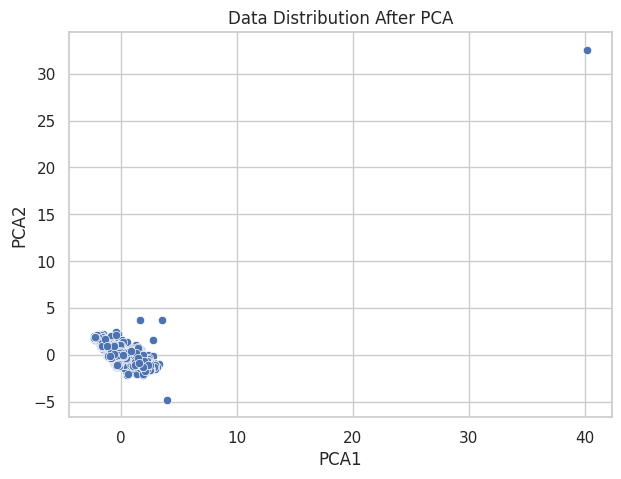

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(x='PCA1', y='PCA2', data=df)
plt.title('Data Distribution After PCA')
plt.show()

New Silhouette Score (PCA+KMeans): 0.514


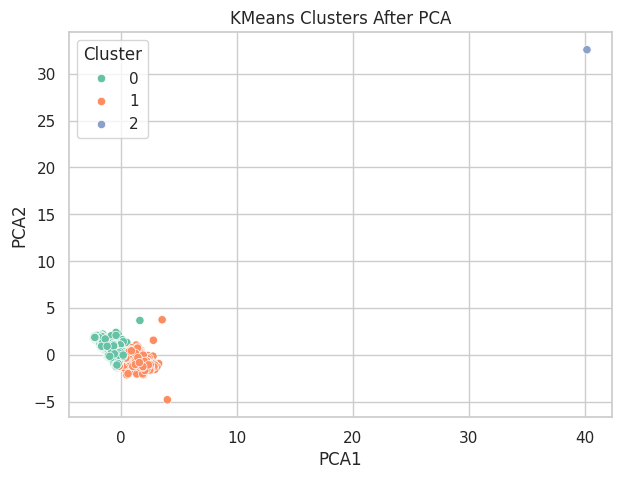

In [26]:
kmeans_final = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_pca)

silhouette = silhouette_score(X_pca, df['Cluster'])
print(f"New Silhouette Score (PCA+KMeans): {silhouette:.3f}")

plt.figure(figsize=(7,5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=df)
plt.title('KMeans Clusters After PCA')
plt.show()

GMM Silhouette Score: 0.432


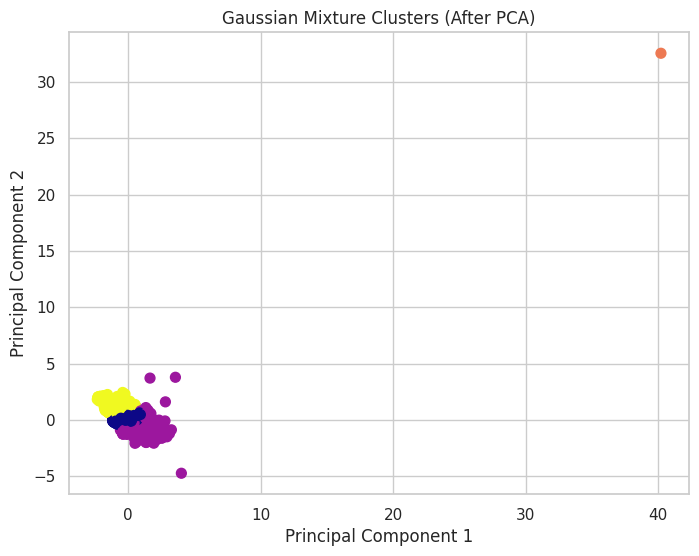

In [27]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(X_pca)

gmm_score = silhouette_score(X_pca, df['Cluster_GMM'])
print(f"GMM Silhouette Score: {gmm_score:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster_GMM'], cmap='plasma', s=50)
plt.title('Gaussian Mixture Clusters (After PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [28]:
import umap.umap_ as umap
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

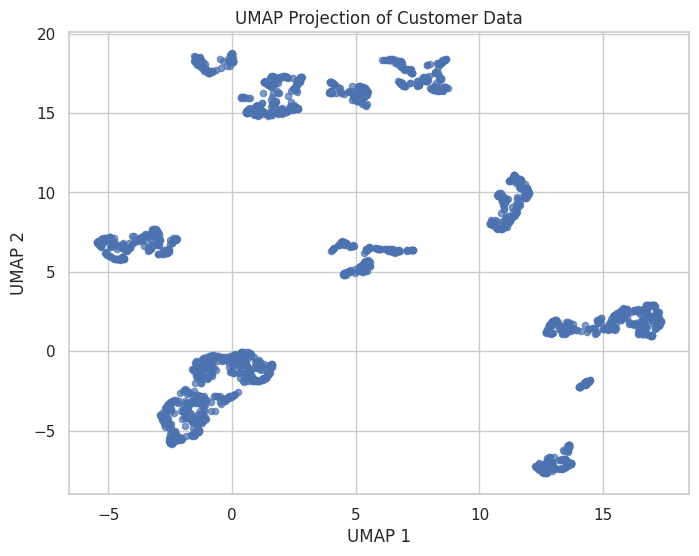

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], s=20, alpha=0.7)
plt.title("UMAP Projection of Customer Data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [30]:
results = {}

# Test different cluster counts
for k in range(3,7):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=500, random_state=42)
    k_labels = kmeans.fit_predict(X_umap)
    k_score = silhouette_score(X_umap, k_labels)
    results[f'KMeans_k={k}'] = k_score

    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    g_labels = gmm.fit_predict(X_umap)
    g_score = silhouette_score(X_umap, g_labels)
    results[f'GMM_k={k}'] = g_score

# Show comparison
for model, score in results.items():
    print(f"{model}: Silhouette Score = {score:.3f}")

KMeans_k=3: Silhouette Score = 0.563
GMM_k=3: Silhouette Score = 0.566
KMeans_k=4: Silhouette Score = 0.600
GMM_k=4: Silhouette Score = 0.600
KMeans_k=5: Silhouette Score = 0.652
GMM_k=5: Silhouette Score = 0.652
KMeans_k=6: Silhouette Score = 0.681
GMM_k=6: Silhouette Score = 0.647


In [31]:
best_model_name = max(results, key=results.get)
best_score = results[best_model_name]
print(f"\n✅ Best Model: {best_model_name} with Silhouette Score = {best_score:.3f}")


✅ Best Model: KMeans_k=6 with Silhouette Score = 0.681


In [32]:
best_k = int(best_model_name.split('=')[1])
best_method = 'GMM' if 'GMM' in best_model_name else 'KMeans'

if best_method == 'KMeans':
    final_model = KMeans(n_clusters=best_k, random_state=42)
else:
    final_model = GaussianMixture(n_components=best_k, random_state=42)

df["Cluster"] = final_model.fit_predict(X_umap)

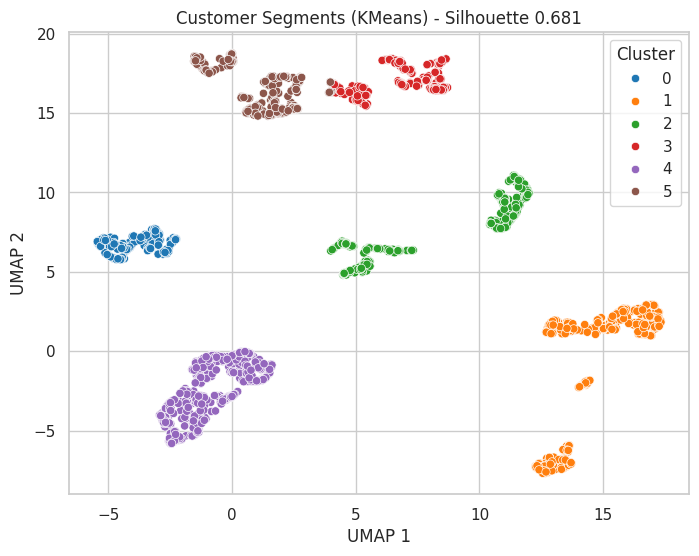

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue= df["Cluster"], palette='tab10')
plt.title(f"Customer Segments ({best_method}) - Silhouette {best_score:.3f}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()

In [34]:
cluster_summary = df.groupby('Cluster')[features].mean().round(2)
print("\n🧾 Cluster Summary:")
display(cluster_summary)


🧾 Cluster Summary:


,Income,Age,TotalSpent,Kids_Teens,FamilySize,TotalAcceptedCmp,CustomerForYears,SpendingEfficiency,CampaignSuccessRate
Cluster,,,,,,,,,
0,45441.69,53.07,264.45,1.00,2.00,0.00,11.00,0.00,0.00
1,44522.07,59.62,241.71,2.11,3.11,0.12,11.91,0.00,0.02
2,49578.88,54.60,667.72,1.01,2.01,0.59,12.55,0.01,0.12
3,74202.17,55.93,1470.31,0.01,1.01,1.23,12.19,0.02,0.25
4,45928.67,55.34,420.46,1.00,2.00,0.00,12.00,0.01,0.00
5,60179.36,56.75,769.02,0.01,1.01,0.03,11.78,0.01,0.01


In [35]:
df.to_csv("customer_segments_final.csv", index=False)
print("✅ File saved as 'customer_segments_final.csv'")

✅ File saved as 'customer_segments_final.csv'
